In [39]:
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [4]:
!pip install nltk==3.8.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.


In [45]:
from transformers import pipeline  # Hugging Face transformers


In [10]:
import json
import nltk
from nltk.tokenize import sent_tokenize
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [36]:
from random import choice

# Step 1: Load dataset (Now without emotions pre-labeled)
dataset= [
        {
            "title": "A Farewell",
            "story": [
                {
                    "text": (
                        "It was a quiet afternoon when she met him for the last time. "
                        "Her heart was heavy with the weight of the impending goodbye, but she tried to smile, to make the best of the situation. "
                        "As they walked along the quiet street, her thoughts were a whirlwind. How had it come to this? "
                        "She had known this moment was coming, but no amount of preparation could make it easier. "
                        "Her heart ached, the sadness settling in like a dark cloud. "
                        "She reached for his hand, but he pulled away. 'I can't do this anymore,' he said, his voice shaking with emotion. "
                        "Tears welled up in her eyes, but she forced them back. She had to stay strong. 'You don't mean that,' she whispered, "
                        "her voice thick with emotion. But the more she looked at him, the more she realized that maybe, just maybe, he did mean it. "
                        "The anger inside her simmered, but as he turned to leave, she felt a strange sense of relief. "
                        "Maybe this was the end they both needed. But as he walked away, the sadness returned, heavier than before. "
                        "She stood there for what felt like hours, watching him disappear into the distance, knowing that things would never be the same again. "
                        "She didn't know whether to cry, scream, or just let the numbness take over. But one thing was certain: she would never forget this moment. "
                        "The goodbye was final, and the sadness lingered like a shadow, even as she tried to move on."
                    )
                }
            ]
        },
        {
            "title": "A Family Reunion",
            "story": [
                {
                    "text": (
                        "The family gathered at the old house for the reunion, with laughter and chatter filling the air. "
                        "Everyone seemed happy to be together, but deep down, she couldn't help but feel uneasy. "
                        "The past had a way of creeping up on her, and as she looked around, the faces of her relatives reminded her of old wounds that never fully healed. "
                        "Her uncle cracked a joke, making everyone laugh, but for her, it felt forced. She tried to smile, but it didn’t quite reach her eyes. "
                        "In the midst of the joy, a wave of frustration bubbled inside her, a feeling she couldn't shake. "
                        "But just as quickly, the warmth of the room brought her comfort, and she felt a fleeting sense of happiness mixed with sadness. "
                        "This was the family she loved, yet there were parts of her that longed to escape. "
                        "Her mother asked her how things were going, and as she replied with a polite 'fine,' a surge of guilt washed over her. "
                        "She felt like a stranger in her own family, a strange mixture of affection and resentment twisting inside her. "
                        "The evening ended with a toast, and while the room echoed with cheer, she couldn’t shake the mix of emotions – joy, anger, relief, and sadness – that seemed to define her experience."
                    )
                }
            ]
        }
    ]


In [46]:

def preprocess_text(dataset):
    # Load spaCy NLP model
    nlp = spacy.load("en_core_web_sm")

    # Initialize VADER sentiment intensity analyzer
    analyzer = SentimentIntensityAnalyzer()

    # Initialize the emotion classification pipeline (using Hugging Face)
    emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

    processed_data = []

    # Define Ekman emotions with labels
    ekman_emotions = {
        "anger": 1,
        "disgust": 2,
        "fear": 3,
        "happiness": 4,
        "sadness": 5,
        "surprise": 6
    }

    for story in dataset:
        paragraphs = []
        emotions = []
        entities = []
        emotion_intensity = []

        for entry in story["story"]:
            text = entry["text"]
            sentences = sent_tokenize(text)

            for sent in sentences:
                doc = nlp(sent)
                paragraphs.append(sent)

                # Perform sentiment analysis on the sentence using VADER
                sentiment_score = analyzer.polarity_scores(sent)["compound"]

                # Get emotion prediction from the LLM
                emotion_result = emotion_classifier(sent)[0]  # Getting the top prediction
                emotion = emotion_result["label"].lower()  # 'label' will contain emotion like 'anger', 'fear', etc.

                # Map the detected emotion to Ekman emotions
                labeled_emotion = ekman_emotions.get(emotion, 0)

                # Append the emotion and its intensity
                emotions.append(emotion)
                emotion_intensity.append(labeled_emotion)

                # Extract named entities from the sentence
                entities.append([ent.text for ent in doc.ents])

        processed_data.append({
            "title": story["title"],
            "paragraphs": paragraphs,
            "emotions": emotions,
            "emotion_intensity": emotion_intensity,
            "entities": entities
        })

    return processed_data

In [49]:
def visualize_emotion_shifts(processed_data):
    for story in processed_data:
        df = pd.DataFrame({"Paragraph": range(len(story["emotions"])),
                           "Emotion": story["emotions"],
                           "Emotion Intensity": story["emotion_intensity"],
                           "Entities": story["entities"]})  # Include entities in the DataFrame

        plt.figure(figsize=(10, 5))
        sns.lineplot(data=df, x="Paragraph", y="Emotion Intensity", marker="o")

        # Annotate entities on the plot
        for i, row in df.iterrows():
            for entity in row["Entities"]:
                plt.annotate(entity, (row["Paragraph"], row["Emotion Intensity"]),
                             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

        plt.xticks(df["Paragraph"], story["paragraphs"], rotation=45, ha='right')
        plt.xlabel("Story Progression")
        plt.ylabel("Emotional Intensity")
        plt.title(f"Emotion Shift in {story['title']}")
        plt.tight_layout()  # Adjust layout to prevent overlapping
        plt.show()

In [47]:
# Step 4: Save processed data
def save_processed_data(processed_data):
    with open("processed_emotion_data.json", "w") as f:
        json.dump(processed_data, f, indent=4)

In [52]:
processed_data = preprocess_text(dataset)

Device set to use cpu


<ipython-input-49-b171d2090830>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to prevent overlapping


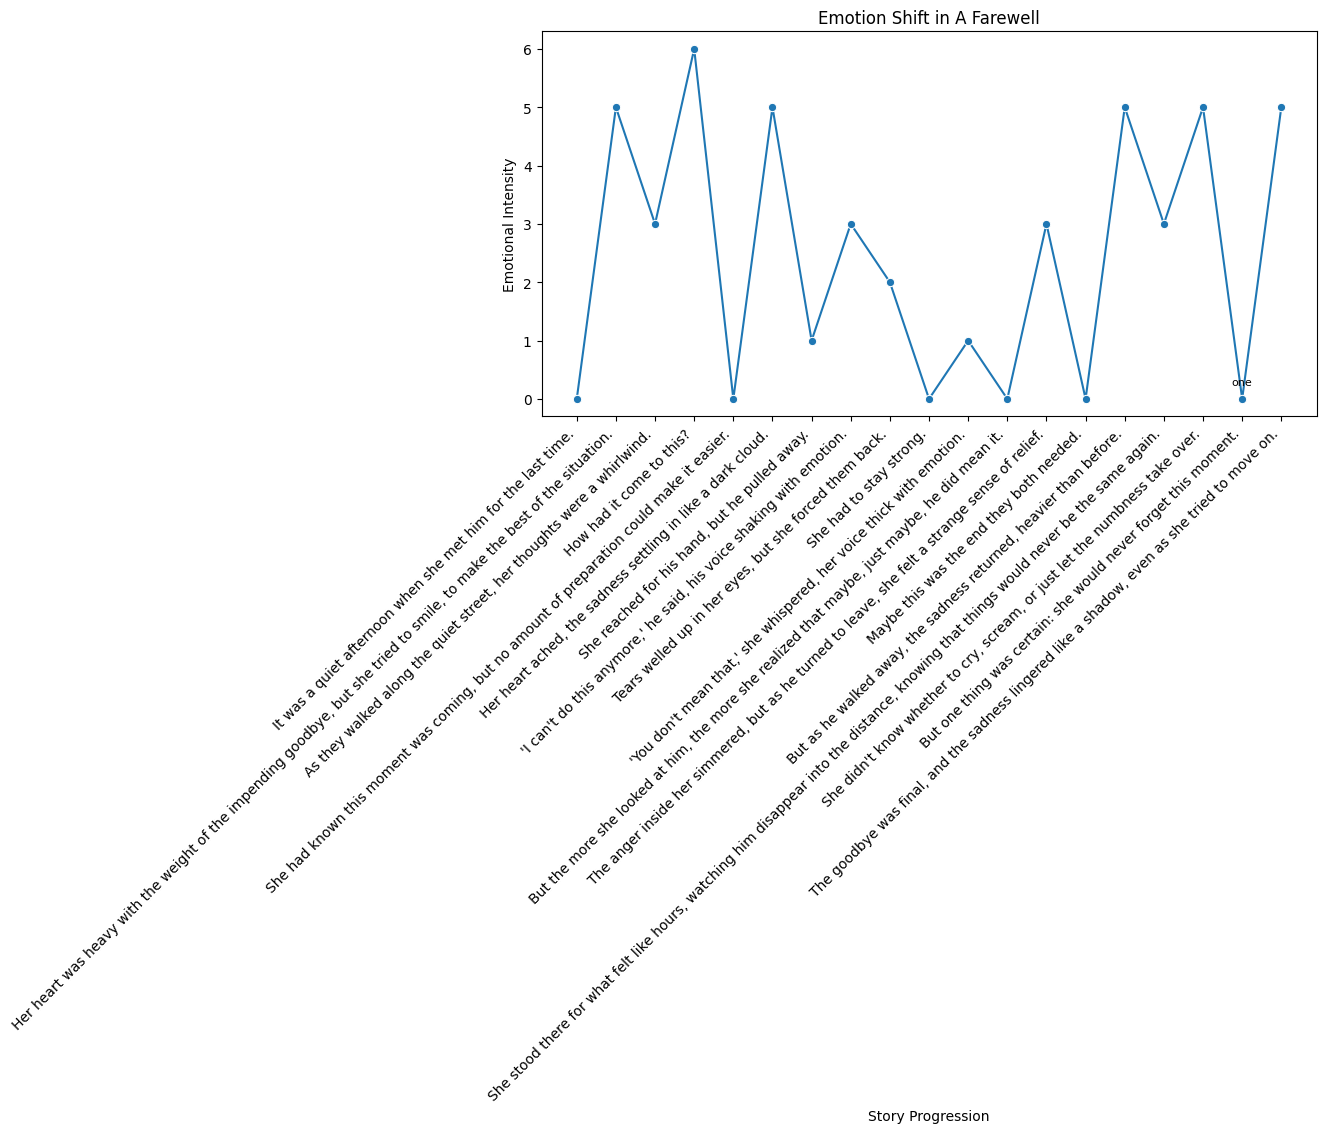

<ipython-input-49-b171d2090830>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to prevent overlapping


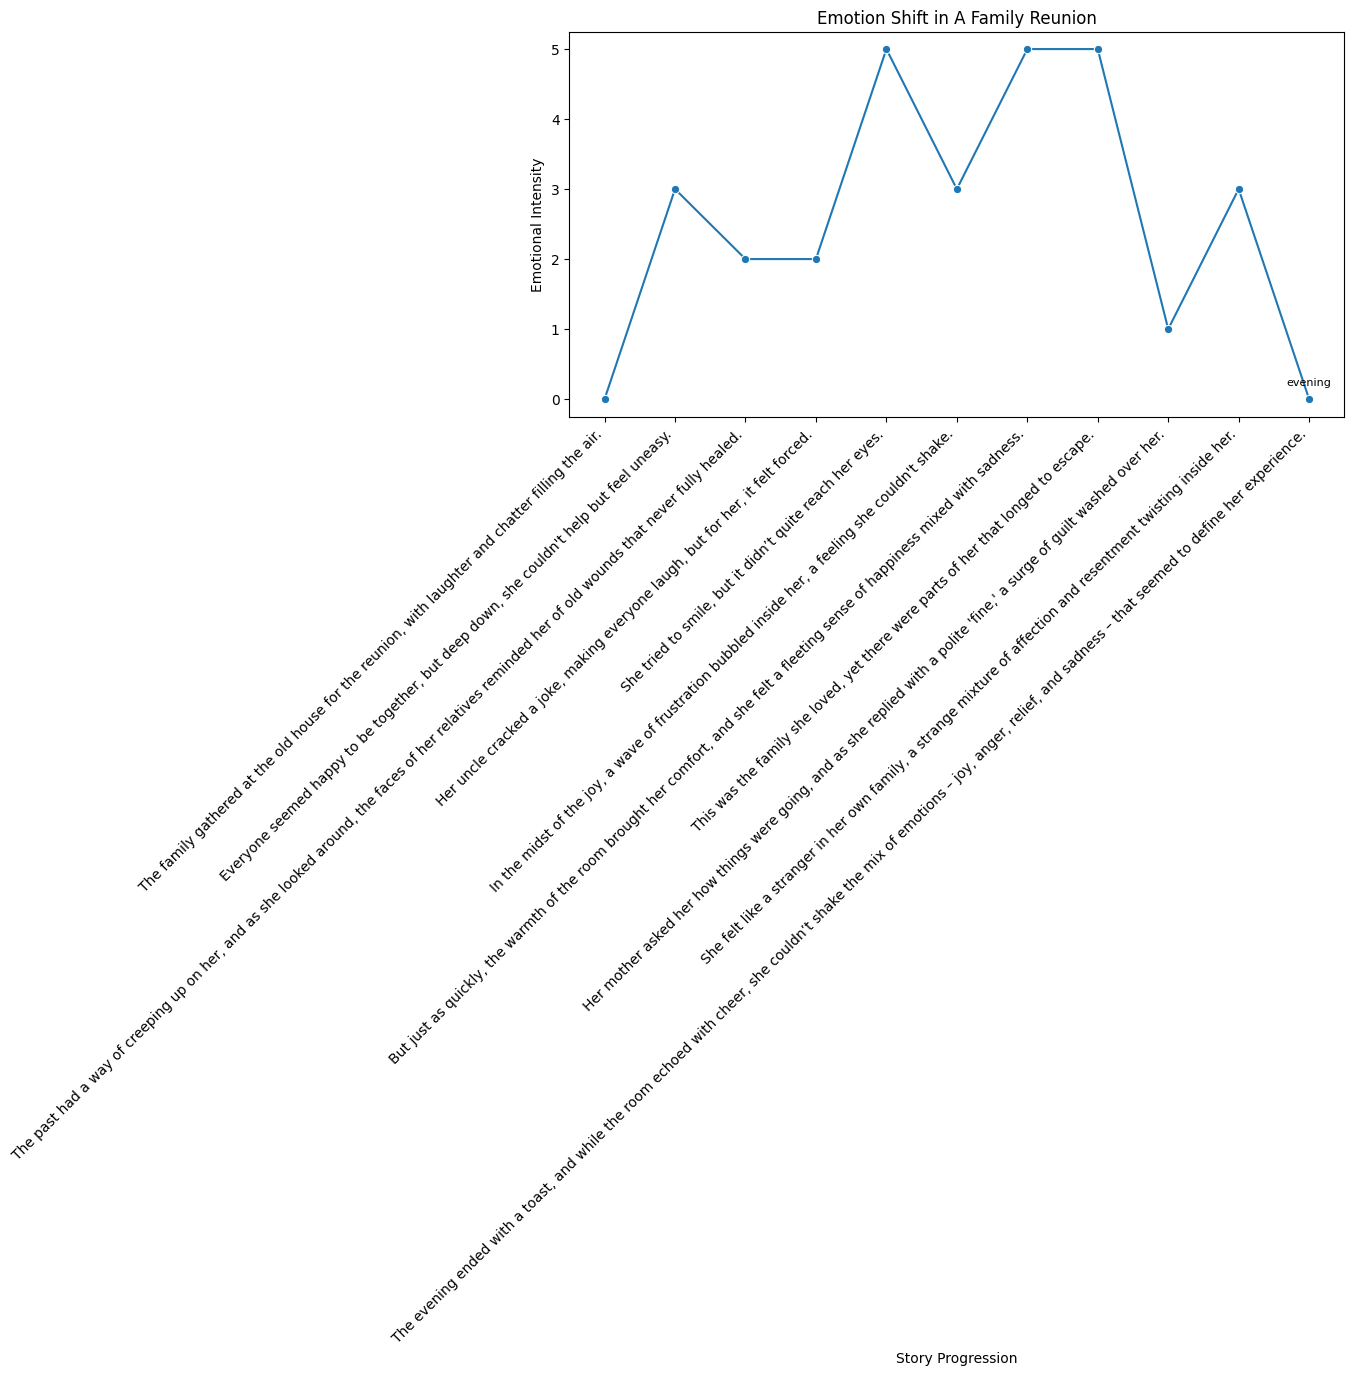

In [53]:
visualize_emotion_shifts(processed_data)
